In [1]:
import pandas as pd
import numpy as np

Read the dataframe

In [2]:
df = pd.read_csv("bank_marketing_data.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Remove rows:
- `default` - almost all values are negative
- `duration` - value unknown before call. Can't be used for prediction
- `pdays` - value equal to 999 if the call has never been made before
- `poutcome` - almost all values are nonexistent

In [3]:
df = df.drop(["default", "duration", "pdays", "poutcome"], axis=1)

Remove illiterate examples as there's only a few of them

In [4]:
df = df.drop(df.loc[df["education"] == "illiterate"].index)

Encode numerical values

In [5]:
education_mapping = {
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "primary",
    "high.school": "secondary",
    "professional.course": "secondary",
    "university.degree": "tertiary",
}

contact_mapping = {
    "telephone": 0,
    "cellular": 1,
}

month_mapping = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12,
}

day_of_week_mapping = {
    "mon": 1,
    "tue": 2,
    "wed": 3,
    "thu": 4,
    "fri": 5,
}

y_mapping = {
    "no": 0,
    "yes": 1,
}

In [6]:
df = df.replace({"education":education_mapping,"contact":contact_mapping,"month":month_mapping,"day_of_week":day_of_week_mapping,"y":y_mapping})

Extract the target variable and check for missing values

In [7]:
y = df["y"]
df = df.drop("y", axis=1)

<Axes: >

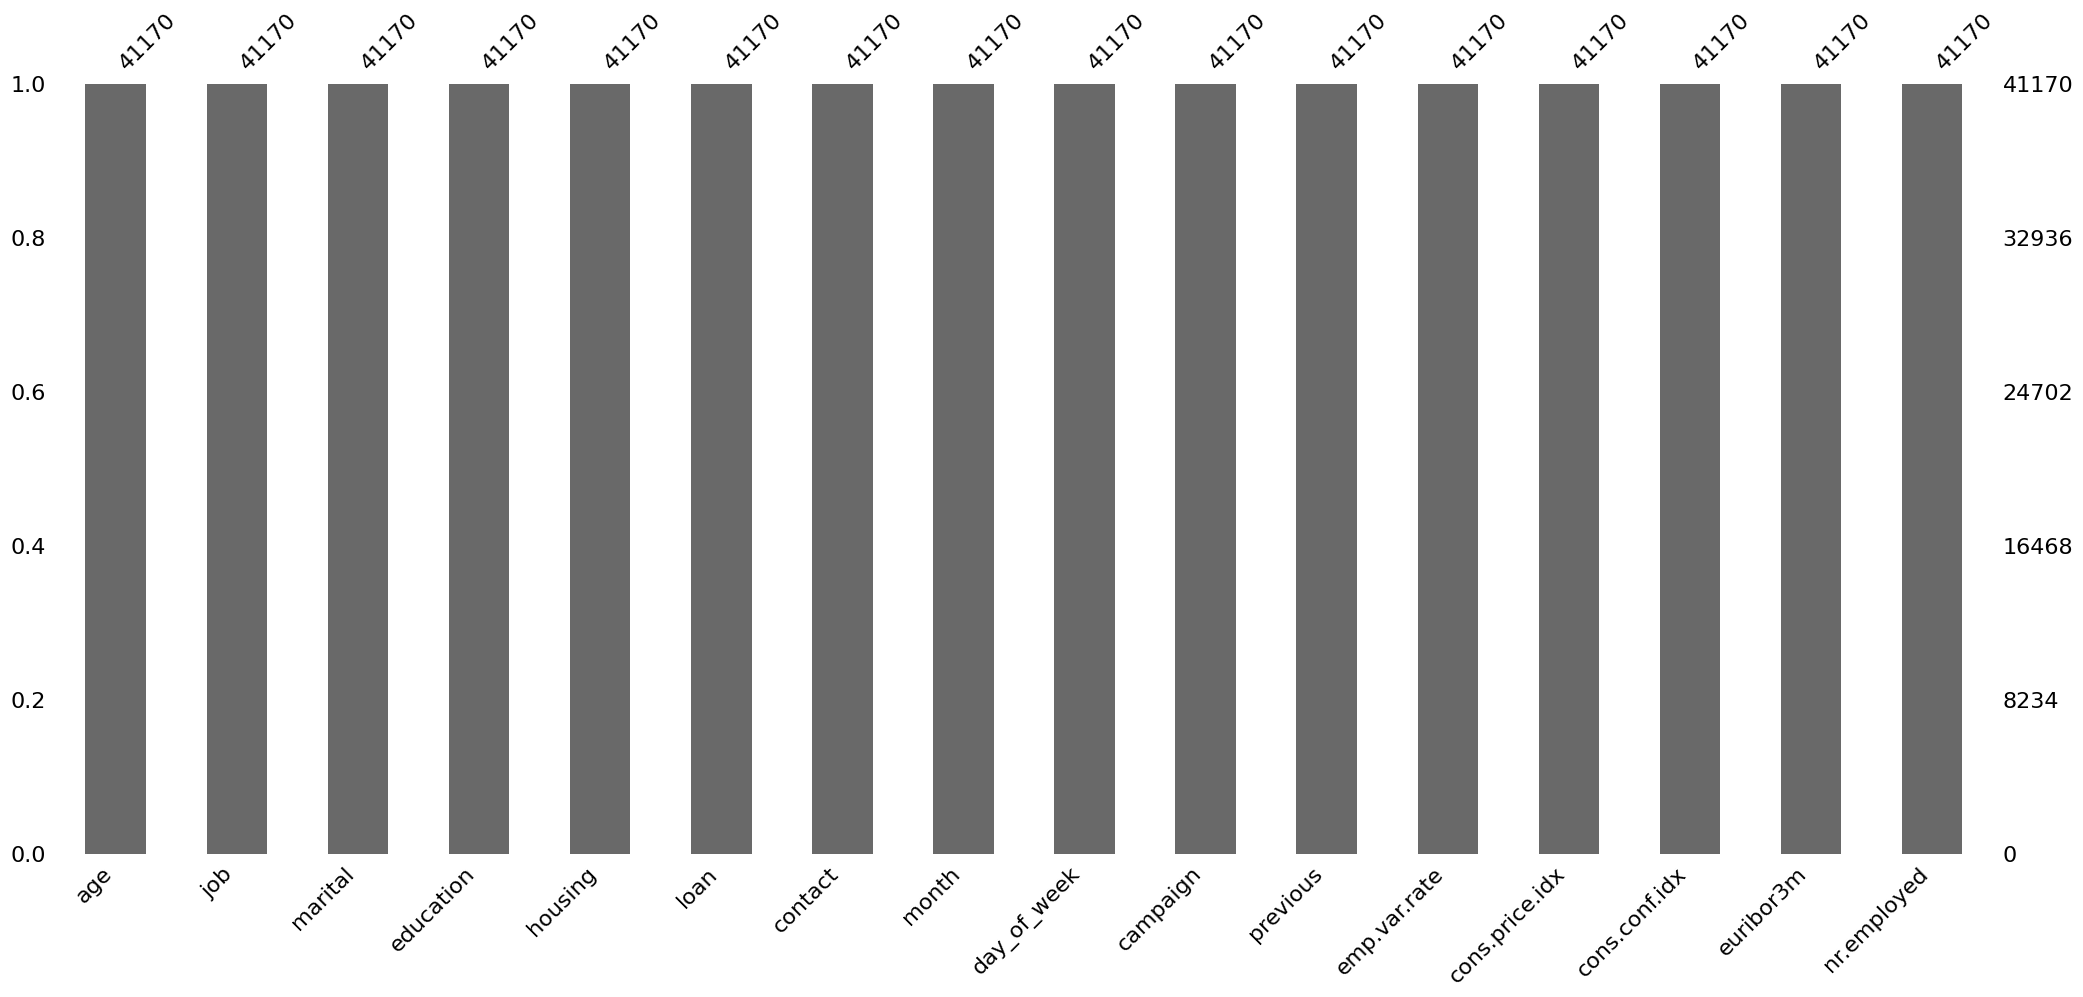

In [8]:
import missingno as msno

msno.bar(df)

Separate the data into training and testing set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=0, stratify=y
)

Encoding and scaling data

Extracting categorical and numerical features

In [10]:


categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

Encoder for categorical features

In [11]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

Imputer and scaler for numerical features

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

median_imputer = SimpleImputer(strategy="median")
std_scaler = StandardScaler()

Creating a pipeline

In [13]:

from sklearn.pipeline import Pipeline


categorical_pipeline = Pipeline(steps=[("onehot", one_hot_encoder)])
numerical_pipeline = Pipeline(
    steps=[("imputer", median_imputer), ("scaler", std_scaler)]
)



Creating and using a columne transformer

In [14]:
from sklearn.compose import ColumnTransformer
column_transformer = ColumnTransformer(
    [
        ("categorical", categorical_pipeline, categorical_features),
        ("numerical", numerical_pipeline, numerical_features),
    ]
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training 3 different logistic regression models to compare

In [15]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

logreg = LogisticRegression(class_weight="balanced", penalty="none")
logreg.fit(X_train, y_train)

y_pred = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred) * 100

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


77.15578030712507

In [16]:
logreg_cv_l2 = LogisticRegressionCV(
    Cs=100, cv=5, scoring="roc_auc", class_weight="balanced", random_state=0, n_jobs=-1
)
logreg_cv_l2.fit(X_train, y_train)

y_pred = logreg_cv_l2.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred) * 100

77.14199362837235

In [17]:
logreg_cv_l1 = LogisticRegressionCV(
    penalty="l1",
    solver="saga",
    Cs=100,
    cv=5,
    scoring="roc_auc",
    class_weight="balanced",
    random_state=0,
    n_jobs=-1,
)
logreg_cv_l1.fit(X_train, y_train)

y_pred = logreg_cv_l1.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred) * 100

77.09214148920313

The results are more or less similar. Let's try to visualize the feature importance

<Axes: title={'center': 'parameter values of the best features'}>

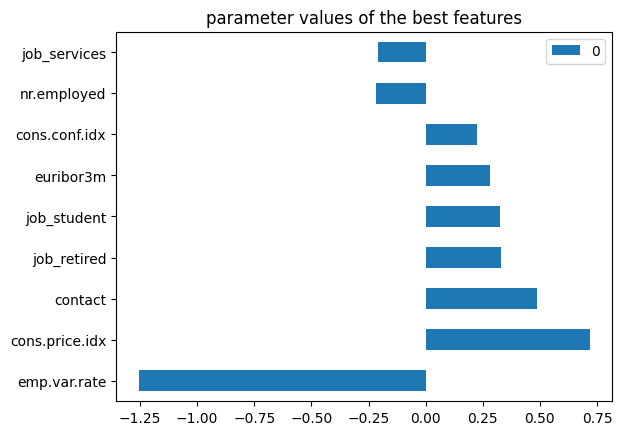

In [18]:
feature_names = column_transformer.get_feature_names_out()
for i, name in enumerate(feature_names):
    if name[0] == "c":
        feature_names[i] = name[len("categorical__") :]
    else:
        feature_names[i] = name[len("numerical__") :]

best_vals = logreg_cv_l2.coef_[0][np.argsort(np.abs(logreg_cv_l2.coef_[0]))[:-10:-1]]

best_features = feature_names[np.argsort(np.abs(logreg_cv_l2.coef_[0]))[:-10:-1]]

pd.DataFrame(best_vals, index=best_features).plot.barh(
    title="parameter values of the best features"
)

What percentage of the  and what features got removed?

In [19]:
print(np.sum(logreg_cv_l1.coef_ == 0) / len(logreg_cv_l1.coef_[0])*100)
np.sort(feature_names[(logreg_cv_l1.coef_ == 0)[0]])

45.94594594594595


array(['age', 'euribor3m', 'housing_unknown', 'housing_yes', 'job_admin.',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_self-employed', 'job_technician', 'job_unemployed',
       'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_unknown'], dtype=object)

It's important to check the scores on the training set

In [20]:
y_pred = logreg.predict_proba(X_train)[:,1]
print("logreg")
print(roc_auc_score(y_train, y_pred) * 100)
print()

y_pred = logreg_cv_l2.predict_proba(X_train)[:,1]
print("logreg L2")
print(roc_auc_score(y_train, y_pred) * 100)
print()

y_pred = logreg_cv_l1.predict_proba(X_train)[:,1]
print("logreg L1")
print(roc_auc_score(y_train, y_pred) * 100)

logreg
77.78968256467422

logreg L2
77.79671469867682

logreg L1
77.83324411303477


Let's see if adding polynomial features improves the scores

In [21]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=0, stratify=y
)

categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

median_imputer = SimpleImputer(strategy="median")
std_scaler = StandardScaler()
polynomials = PolynomialFeatures(interaction_only=True, include_bias=False)

categorical_pipeline = Pipeline(steps=[("onehot", one_hot_encoder)])
numerical_pipeline = Pipeline(
    steps=[
        ("imputer", median_imputer),
        ("polynomial", polynomials),
        ("scaler", std_scaler),
    ]
)

column_transformer = ColumnTransformer(
    [
        ("categorical", categorical_pipeline, categorical_features),
        ("numerical", numerical_pipeline, numerical_features),
    ]
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
logreg = LogisticRegression(class_weight="balanced", penalty="none")
logreg.fit(X_train, y_train)


y_pred = logreg.predict_proba(X_train)[:,1]
train_score = roc_auc_score(y_train, y_pred) * 100

y_pred = logreg.predict_proba(X_test)[:,1]
test_score = roc_auc_score(y_test, y_pred) * 100

print("train score : ",train_score)
print("test  score : ",test_score)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


train score :  79.53468412865357
test  score :  78.62478658750277


C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
